In [19]:

import os
import json
import math
import time
import re
from urllib.parse import urlparse

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from firebase import db
from sentence_transformers import SentenceTransformer
from rapidfuzz import fuzz, process

In [20]:
plt.rcParams["figure.figsize"] = (8,4)

# Config
PLAN_ID = "31e03418-6931-4043-88af-c1e7f1b24add"   # or leave as None to auto-pick the most recent
SEM_MODEL_NAME = "all-MiniLM-L6-v2"
SEM_THRESHOLD = 0.60  # similarity cutoff for "relevant"
DUP_VECTOR_THRESHOLD = 0.90  # cosine similarity for near-duplicate entities

In [21]:
def base_domain(url: str) -> str:
    try:
        p = urlparse(url)
        return p.netloc.lower()
    except Exception:
        return ""

def normalize_name(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def is_scrapable(url: str, timeout=6) -> bool:
    try:
        r = requests.get(url, timeout=timeout)
        return r.status_code == 200 and bool(r.text.strip())
    except Exception:
        return False

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12))


In [22]:
plans_ref = db.collection("research_plans")
if PLAN_ID and PLAN_ID != "#":
    plan_doc = plans_ref.document(PLAN_ID).get()
else:
    # pick the most recent by Firestore timestamp field if you store one; otherwise just take any
    # fallback: grab first doc
    plan_docs = list(plans_ref.stream())
    if not plan_docs:
        raise RuntimeError("No research_plans found.")
    plan_doc = plan_docs[-1]  # naive "latest"

plan = plan_doc.to_dict()
PLAN_ID = plan["plan_id"]
print("Using plan:", PLAN_ID, "| goal:", plan.get("goal"))

results_ref = plans_ref.document(PLAN_ID).collection("results")
subtasks = plan.get("subtasks", [])
for st in subtasks:
    print(f" - {st['id']}: {st['type']} :: {st.get('description','')[:60]}...")


Using plan: 31e03418-6931-4043-88af-c1e7f1b24add | goal: Find a list of hospitals in Ontario.
 - search_001: search :: Search for comprehensive lists and directories relevant to t...
 - validate_001: validate :: Cross-reference the search results to ensure reliability and...
 - scrape_001: scrape :: Fetch and clean the first validated URL, extracting items re...
 - scrape_002: scrape :: Fetch and clean the second validated URL, extracting items r...
 - scrape_003: scrape :: Fetch and clean the third validated URL, extracting items re...
 - aggregate_001: aggregate :: Combine all extracted items from the scrape subtasks into a ...


In [23]:
# Cell 3 — Pull search & validate URL sets for ranking table

# find the first search subtask + first validate subtask
search_ids = [s["id"] for s in subtasks if s["type"] == "search"]
validate_ids = [s["id"] for s in subtasks if s["type"] == "validate"]

search_data = []
for sid in search_ids:
    doc = results_ref.document(sid).get().to_dict() or {}
    for r in doc.get("results", []):
        search_data.append({"source_subtask": sid, **r})

validate_data = []
for vid in validate_ids:
    doc = results_ref.document(vid).get().to_dict() or {}
    for r in doc.get("results", []):
        validate_data.append({"source_subtask": vid, **r})

df_search = pd.DataFrame(search_data) if search_data else pd.DataFrame(columns=["title","snippet","url","source_subtask"])
df_validate = pd.DataFrame(validate_data) if validate_data else pd.DataFrame(columns=["title","snippet","url","source_subtask"])

print("Search URLs:", len(df_search), " | Validated URLs:", len(df_validate))
df_search.head(10)


Search URLs: 25  | Validated URLs: 9


,source_subtask,url,title,snippet
0,search_001,http://www.ontario.ca/page/general-hospital-lo...,General hospital locations | ontario.ca,"Apr 18, 2023 ... Brampton. William Osler Healt..."
1,search_001,https://en.wikipedia.org/wiki/List_of_hospital...,List of hospitals in Canada - Wikipedia,Ontario · Children's Hospital of Eastern Ontar...
2,search_001,http://www.ontario.ca/page/classification-hosp...,Classification of hospitals | ontario.ca,"Apr 26, 2023 ... Kingston. Kingston Health Sci..."
3,search_001,https://www.sinaihealth.ca/our-hospitals/mount...,Mount Sinai Hospital | Sinai Health,Physician directory. Find a specific physician...
4,search_001,https://www.gregmonforton.com/windsor/personal...,Comprehensive Directory of Ontario Hospitals f...,Browse a comprehensive directory of Ontario ho...
5,search_001,https://www.ontario.ca/page/designated-psychia...,Designated psychiatric facilities and hospital...,"Aug 21, 2023 ... Many hospitals in Ontario pro..."
6,search_001,https://sarh.org/,San Antonio Regional Hospital,Embrace San Antonio Regional Hospital in Uplan...
7,search_001,https://www.oha.com/membership/oha-members,Ontario Hospital Association OHA Members,​​Alexandra Hospital · Alexandra Marine & Gene...
8,search_001,https://rankings.newsweek.com/worlds-best-hosp...,Canada's World's Best Hospitals 2024,"To help, Newsweek has partnered with Statista ..."
9,search_001,https://www.cms.gov/team-model-participant-list,TEAM Participant List,CMS will identify and share a list of hospital...


In [24]:
# Cell 4 — Semantic ranking table on SEARCH results (title+snippet vs GOAL)

model = SentenceTransformer(SEM_MODEL_NAME)

def score_sem_similarity(row, query, _model):
    text = ((row.get("title") or "") + " " + (row.get("snippet") or "")).strip()
    if not text:
        return 0.0
    qv = _model.encode(query, convert_to_numpy=True)
    tv = _model.encode(text, convert_to_numpy=True)
    return cosine_sim(qv, tv)

goal = plan.get("goal","")
if not df_search.empty:
    df_search["similarity_score"] = df_search.apply(lambda r: score_sem_similarity(r, goal, model), axis=1)
    df_search["base_domain"] = df_search["url"].apply(base_domain)
    df_ranked = df_search.sort_values("similarity_score", ascending=False).reset_index(drop=True)
    # optional threshold view
    df_ranked_above = df_ranked[df_ranked["similarity_score"] >= SEM_THRESHOLD].reset_index(drop=True)
else:
    df_ranked = pd.DataFrame()
    df_ranked_above = pd.DataFrame()

print(f"Top 10 ranked (search):")
df_ranked.head(10)


Top 10 ranked (search):


,source_subtask,url,title,snippet,similarity_score,base_domain
0,search_001,https://ca.usembassy.gov/wp-content/uploads/si...,LIST OF ONTARIO HOSPITALS & CLINICS,"Nov 28, 2018 ... LIST OF ONTARIO HOSPITALS & C...",0.802614,ca.usembassy.gov
1,search_001,https://en.wikipedia.org/wiki/List_of_hospital...,List of hospitals in Canada - Wikipedia,Ontario · Children's Hospital of Eastern Ontar...,0.777658,en.wikipedia.org
2,search_001,https://www.ontario.ca/page/designated-psychia...,Designated psychiatric facilities and hospital...,"Aug 21, 2023 ... Many hospitals in Ontario pro...",0.737570,www.ontario.ca
3,search_001,https://www.gregmonforton.com/windsor/personal...,Comprehensive Directory of Ontario Hospitals f...,Browse a comprehensive directory of Ontario ho...,0.722286,www.gregmonforton.com
4,search_001,https://www.wrh.on.ca/,Windsor Regional Hospital - Home,A-Z Listing · Emergency Services · Cancer Prog...,0.693789,www.wrh.on.ca
5,search_001,https://healthy.kaiserpermanente.org/southern-...,Ontario Medical Center | Kaiser Permanente,"Mar 17, 2025 ... The information in this onlin...",0.690101,healthy.kaiserpermanente.org
6,search_001,http://www.ontario.ca/page/classification-hosp...,Classification of hospitals | ontario.ca,"Apr 26, 2023 ... Kingston. Kingston Health Sci...",0.665606,www.ontario.ca
7,search_001,https://www.cms.gov/team-model-participant-list,TEAM Participant List,CMS will identify and share a list of hospital...,0.644086,www.cms.gov
8,search_001,https://www.pcmch.on.ca/wp-content/uploads/LOC...,"Perinatal, Birthing and Newborn Levels of Care...","Mar 1, 2023 ... Children's Hospital of Eastern...",0.638449,www.pcmch.on.ca
9,search_001,http://www.ontario.ca/page/general-hospital-lo...,General hospital locations | ontario.ca,"Apr 18, 2023 ... Brampton. William Osler Healt...",0.625206,www.ontario.ca


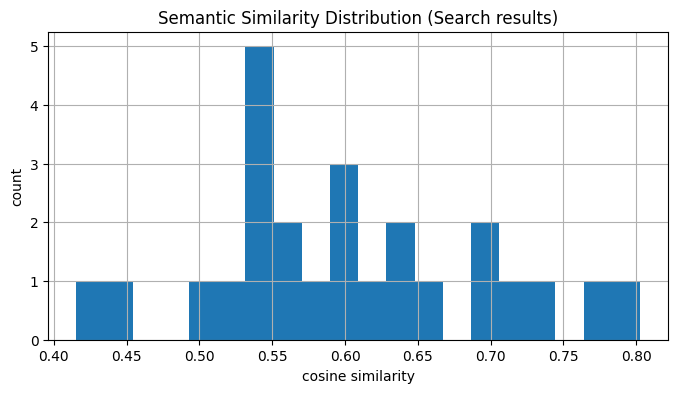

Coverage above threshold 0.60: 40.0%


In [25]:
# Cell 5 — Plot similarity distribution & threshold coverage

if not df_ranked.empty:
    plt.figure()
    df_ranked["similarity_score"].hist(bins=20)
    plt.title("Semantic Similarity Distribution (Search results)")
    plt.xlabel("cosine similarity")
    plt.ylabel("count")
    plt.show()

    covered = (df_ranked["similarity_score"] >= SEM_THRESHOLD).mean() if not df_ranked.empty else 0.0
    print(f"Coverage above threshold {SEM_THRESHOLD:.2f}: {covered*100:.1f}%")


In [26]:
# Cell 6 — Table: URLs & Scores

cols = ["similarity_score","title","url","base_domain","snippet","source_subtask"]
(df_ranked[cols].head(25) if not df_ranked.empty else pd.DataFrame(columns=cols))


,similarity_score,title,url,base_domain,snippet,source_subtask
0,0.802614,LIST OF ONTARIO HOSPITALS & CLINICS,https://ca.usembassy.gov/wp-content/uploads/si...,ca.usembassy.gov,"Nov 28, 2018 ... LIST OF ONTARIO HOSPITALS & C...",search_001
1,0.777658,List of hospitals in Canada - Wikipedia,https://en.wikipedia.org/wiki/List_of_hospital...,en.wikipedia.org,Ontario · Children's Hospital of Eastern Ontar...,search_001
2,0.737570,Designated psychiatric facilities and hospital...,https://www.ontario.ca/page/designated-psychia...,www.ontario.ca,"Aug 21, 2023 ... Many hospitals in Ontario pro...",search_001
3,0.722286,Comprehensive Directory of Ontario Hospitals f...,https://www.gregmonforton.com/windsor/personal...,www.gregmonforton.com,Browse a comprehensive directory of Ontario ho...,search_001
4,0.693789,Windsor Regional Hospital - Home,https://www.wrh.on.ca/,www.wrh.on.ca,A-Z Listing · Emergency Services · Cancer Prog...,search_001
5,0.690101,Ontario Medical Center | Kaiser Permanente,https://healthy.kaiserpermanente.org/southern-...,healthy.kaiserpermanente.org,"Mar 17, 2025 ... The information in this onlin...",search_001
6,0.665606,Classification of hospitals | ontario.ca,http://www.ontario.ca/page/classification-hosp...,www.ontario.ca,"Apr 26, 2023 ... Kingston. Kingston Health Sci...",search_001
7,0.644086,TEAM Participant List,https://www.cms.gov/team-model-participant-list,www.cms.gov,CMS will identify and share a list of hospital...,search_001
8,0.638449,"Perinatal, Birthing and Newborn Levels of Care...",https://www.pcmch.on.ca/wp-content/uploads/LOC...,www.pcmch.on.ca,"Mar 1, 2023 ... Children's Hospital of Eastern...",search_001
9,0.625206,General hospital locations | ontario.ca,http://www.ontario.ca/page/general-hospital-lo...,www.ontario.ca,"Apr 18, 2023 ... Brampton. William Osler Healt...",search_001


In [27]:
# Cell 7 — Name/Address duplicate checks (sorted & fuzzy string similarity)

scrape_ids = [s["id"] for s in subtasks if s["type"] == "scrape"]
scraped_items = []
for sid in scrape_ids:
    doc = results_ref.document(sid).get().to_dict() or {}
    for item in doc.get("results", []):
        scraped_items.append({
            "subtask": sid,
            "name": item.get("name",""),
            "address": item.get("address","")
        })

df_scrape = pd.DataFrame(scraped_items) if scraped_items else pd.DataFrame(columns=["subtask","name","address"])
print("Total scraped items:", len(df_scrape))

if not df_scrape.empty:
    df_scrape["name_norm"] = df_scrape["name"].apply(normalize_name)
    df_scrape["address_norm"] = df_scrape["address"].apply(normalize_name)

    df_sorted = df_scrape.sort_values(["name_norm","address_norm"]).reset_index(drop=True)
    potential_dupes = []
    for i in range(1, len(df_sorted)):
        n1, a1 = df_sorted.loc[i-1, ["name_norm","address_norm"]]
        n2, a2 = df_sorted.loc[i,   ["name_norm","address_norm"]]
        name_ratio = fuzz.token_set_ratio(n1, n2)
        addr_ratio = fuzz.token_set_ratio(a1, a2)
        if name_ratio >= 90 or addr_ratio >= 90:
            potential_dupes.append({
                "row_prev": i-1, "row_curr": i,
                "name_prev": df_sorted.loc[i-1, "name"], "name_curr": df_sorted.loc[i, "name"],
                "addr_prev": df_sorted.loc[i-1, "address"], "addr_curr": df_sorted.loc[i, "address"],
                "name_ratio": name_ratio, "addr_ratio": addr_ratio
            })

    df_dupes_str = pd.DataFrame(potential_dupes)
    print(f"Potential string-based duplicates found: {len(df_dupes_str)}\n")

    # Print first few examples
    for _, row in df_dupes_str.head(5).iterrows():
        print(f"Example duplicate:\n"
              f"  • Name A: {row['name_prev']}\n    Addr A: {row['addr_prev']}\n"
              f"  • Name B: {row['name_curr']}\n    Addr B: {row['addr_curr']}\n"
              f"    (name_ratio={row['name_ratio']}, addr_ratio={row['addr_ratio']})\n")
else:
    df_dupes_str = pd.DataFrame()


Total scraped items: 227
Potential string-based duplicates found: 164

Example duplicate:
  • Name A: Baycrest Health Sciences
    Addr A: Toronto, Ontario
  • Name B: Baycrest Health Sciences
    Addr B: Toronto, Ontario
    (name_ratio=100.0, addr_ratio=100.0)

Example duplicate:
  • Name A: Baycrest Health Sciences
    Addr A: Toronto, Ontario
  • Name B: Baycrest Health Sciences
    Addr B: Toronto, Ontario
    (name_ratio=100.0, addr_ratio=100.0)

Example duplicate:
  • Name A: Blanche River Health
    Addr A: Kirkland Lake, Ontario
  • Name B: Blanche River Health
    Addr B: Kirkland Lake, Ontario
    (name_ratio=100.0, addr_ratio=100.0)

Example duplicate:
  • Name A: Blanche River Health
    Addr A: Kirkland Lake, Ontario
  • Name B: Blanche River Health
    Addr B: Kirkland Lake, Ontario, Canada
    (name_ratio=100.0, addr_ratio=100.0)

Example duplicate:
  • Name A: Bluewater Health
    Addr A: Sarnia, Ontario
  • Name B: Bluewater Health
    Addr B: Sarnia, Ontario
    (nam

In [39]:
# Cell 8 — Vector-based duplicate detection for scraped entities (name+address)

if not df_scrape.empty:
    entity_texts = (df_scrape["name"].fillna("") + " " + df_scrape["address"].fillna("")).tolist()
    embs = model.encode(entity_texts, convert_to_numpy=True)

    near_dupes = []
    for i in range(len(embs)):
        for j in range(i+1, len(embs)):
            sim = cosine_sim(embs[i], embs[j])
            if sim >= DUP_VECTOR_THRESHOLD:
                near_dupes.append({
                    "i": i, "j": j,
                    "name_i": df_scrape.loc[i,"name"], "name_j": df_scrape.loc[j,"name"],
                    "addr_i": df_scrape.loc[i,"address"], "addr_j": df_scrape.loc[j,"address"],
                    "sim": sim
                })

    df_dupes_vec = pd.DataFrame(near_dupes)
    print(f"Vector-similar duplicates (>= {DUP_VECTOR_THRESHOLD}): {len(df_dupes_vec)}\n")

    # Print first few examples
    for _, row in df_dupes_vec.head(20).iterrows():
        print(f"Example duplicate:\n"
              f"  • Name A: {row['name_i']}\n    Addr A: {row['addr_i']}\n"
              f"  • Name B: {row['name_j']}\n    Addr B: {row['addr_j']}\n"
              f"    (vector_similarity={row['sim']:.4f})\n")
else:
    df_dupes_vec = pd.DataFrame()


Vector-similar duplicates (>= 0.9): 261

Example duplicate:
  • Name A: William Osler Health System
    Addr A: Brampton, Ontario
  • Name B: William Osler Health System
    Addr B: Brampton, Ontario
    (vector_similarity=1.0000)

Example duplicate:
  • Name A: William Osler Health System
    Addr A: Brampton, Ontario
  • Name B: William Osler Health System
    Addr B: Brampton, Ontario, Canada
    (vector_similarity=0.9783)

Example duplicate:
  • Name A: Muskoka Algonquin Healthcare
    Addr A: Huntsville, Ontario
  • Name B: Muskoka Algonquin Healthcare
    Addr B: Huntsville, Ontario
    (vector_similarity=1.0000)

Example duplicate:
  • Name A: Muskoka Algonquin Healthcare
    Addr A: Huntsville, Ontario
  • Name B: Muskoka Algonquin Healthcare
    Addr B: Huntsville, Ontario, Canada
    (vector_similarity=0.9880)

Example duplicate:
  • Name A: Oak Valley Health
    Addr A: Markham, Ontario
  • Name B: Oak Valley Health
    Addr B: Markham, Ontario
    (vector_similarity=1.0000)

In [29]:
# Cell 9 — Vector-based duplicate detection for scraped entities (name+address)

if not df_scrape.empty:
    entity_texts = (df_scrape["name"].fillna("") + " " + df_scrape["address"].fillna("")).tolist()
    embs = model.encode(entity_texts, convert_to_numpy=True)
    # naive O(n^2) similarity check; fine for hundreds / low thousands
    near_dupes = []
    for i in range(len(embs)):
        for j in range(i+1, len(embs)):
            sim = cosine_sim(embs[i], embs[j])
            if sim >= DUP_VECTOR_THRESHOLD:
                near_dupes.append({
                    "i": i, "j": j,
                    "name_i": df_scrape.loc[i,"name"], "name_j": df_scrape.loc[j,"name"],
                    "addr_i": df_scrape.loc[i,"address"], "addr_j": df_scrape.loc[j,"address"],
                    "sim": sim
                })
    df_dupes_vec = pd.DataFrame(near_dupes)
    print("Vector-similar duplicates (>= {:.2f}): {}".format(DUP_VECTOR_THRESHOLD, len(df_dupes_vec)))
    df_dupes_vec.head(10)
else:
    df_dupes_vec = pd.DataFrame()


Vector-similar duplicates (>= 0.90): 261


In [30]:
# Cell 10 — Scrapability accuracy check on ranking_training_data vs live

# If you built ffnn_dataset with 'malformed_url' and 'gpt_score', compare to live requests
train_docs = list(db.collection("ranking_training_data").stream())
train_rows = [{"title":d.to_dict().get("title",""),
               "snippet":d.to_dict().get("snippet",""),
               "url":d.to_dict().get("url","")} for d in train_docs]
df_train = pd.DataFrame(train_rows)

ffnn_docs = list(db.collection("ffnn_dataset").stream())
ffnn_rows = [d.to_dict() for d in ffnn_docs]
df_ffnn = pd.DataFrame(ffnn_rows)

if not df_ffnn.empty:
    # add live check
    print("Checking live scrapability for a sample of 100 URLs (to keep it quick)...")
    sample = df_train.sample(min(100, len(df_train)), random_state=42).copy()
    sample["live_scrapable"] = sample["url"].apply(is_scrapable)

    # join with ffnn labels if present
    # NOTE: ffnn_dataset rows don't have URL in our earlier draft; if you stored URL, join on it
    # If not, skip this step or adjust to how you stored it.
    # For demonstration, we compute live only:
    live_rate = sample["live_scrapable"].mean()
    print(f"Live scrapable rate on sample: {live_rate*100:.1f}%")
else:
    print("ffnn_dataset not found or empty; skipping scrapability comparison.")


Checking live scrapability for a sample of 100 URLs (to keep it quick)...
Live scrapable rate on sample: 76.0%


Avg similarity by trusted-domain flag:
is_trusted_domain
False    0.578448
True     0.611495
Name: similarity_score, dtype: float64


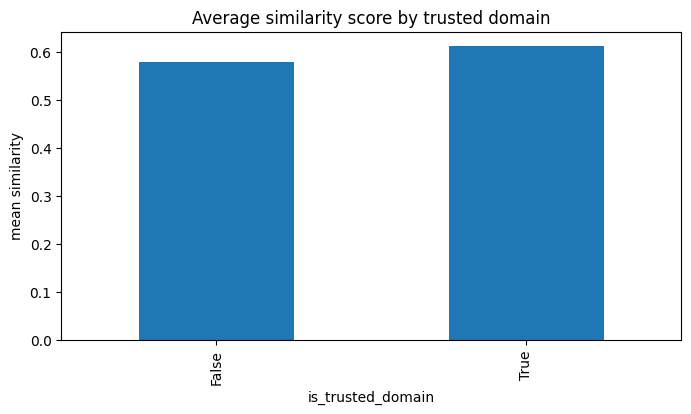

In [38]:
# Cell 11 — Semantic ranker base-domain sanity: are "good" domains scoring higher?

if not df_ranked.empty:
    df_ranked["is_trusted_domain"] = df_ranked["base_domain"].str.endswith(tuple([".gov",".org",".edu", ".ca"]))
    # simple group means
    group_means = df_ranked.groupby("is_trusted_domain")["similarity_score"].mean()
    print("Avg similarity by trusted-domain flag:")
    print(group_means)

    # plot
    plt.figure()
    group_means.plot(kind="bar")
    plt.title("Average similarity score by trusted domain")
    plt.xlabel("is_trusted_domain")
    plt.ylabel("mean similarity")
    plt.show()


In [32]:
# Cell 12 — Automated metrics summary

metrics = {}

# 1) Ranker coverage
if not df_ranked.empty:
    metrics["ranker_coverage@{:.2f}".format(SEM_THRESHOLD)] = float((df_ranked["similarity_score"] >= SEM_THRESHOLD).mean())

# 2) Duplicate rates
if not df_dupes_str.empty:
    metrics["string_dup_pairs"] = int(len(df_dupes_str))
else:
    metrics["string_dup_pairs"] = 0

if not df_dupes_vec.empty:
    metrics["vector_dup_pairs@{:.2f}".format(DUP_VECTOR_THRESHOLD)] = int(len(df_dupes_vec))
else:
    metrics["vector_dup_pairs@{:.2f}".format(DUP_VECTOR_THRESHOLD)] = 0

# 3) Domain composition
if not df_ranked.empty:
    metrics["pct_trusted_domains_in_top50"] = float(df_ranked.head(50)["base_domain"].str.endswith(tuple([".gov",".org",".edu"])).mean())

# 4) Scrapability sample success
# (already printed live rate; store it if you want)
# metrics["live_scrapable_rate_sample"] = live_rate

print(json.dumps(metrics, indent=2))


{
  "ranker_coverage@0.60": 0.4,
  "string_dup_pairs": 164,
  "vector_dup_pairs@0.90": 261,
  "pct_trusted_domains_in_top50": 0.36
}


In [33]:
# Cell 13 — (Optional) Show "summaries" window for context store
# We didn't persist vector store summaries earlier, so reconstruct quick summaries from results.

def quick_search_summary(df):
    if df.empty: 
        return "No search results found."
    doms = df["base_domain"].value_counts().head(5).index.tolist()
    return f"Search: {len(df)} URLs; top domains: {', '.join(doms)}."

def quick_validate_summary(df):
    if df.empty:
        return "No validated URLs."
    doms = df["base_domain"].value_counts().head(5).index.tolist()
    return f"Validate: {len(df)} URLs >= {SEM_THRESHOLD:.2f}; top domains: {', '.join(doms)}."

def quick_scrape_summary(df):
    if df.empty:
        return "No scraped entities."
    examples = ", ".join(df['name'].head(5).tolist())
    return f"Scrape: {len(df)} entities; e.g., {examples}..."

search_summary   = quick_search_summary(df_ranked if not df_ranked.empty else df_search)
validate_summary = quick_validate_summary(df_ranked_above if not df_ranked_above.empty else df_validate)
scrape_summary   = quick_scrape_summary(df_scrape) if not df_scrape.empty else "No scrape outputs."

print("Context Summaries (reconstructed):")
print("-", search_summary)
print("-", validate_summary)
print("-", scrape_summary)


Context Summaries (reconstructed):
- Search: 25 URLs; top domains: www.ontario.ca, healthy.kaiserpermanente.org, ca.usembassy.gov, www.kindredhospitals.com, sarh.org.
- Validate: 10 URLs >= 0.60; top domains: www.ontario.ca, ca.usembassy.gov, en.wikipedia.org, www.gregmonforton.com, www.wrh.on.ca.
- Scrape: 227 entities; e.g., William Osler Health System, Muskoka Algonquin Healthcare, Oak Valley Health, Georgian Bay General Hospital, Trillium Health Partners...
